In [1]:
%pylab inline
%load_ext autoreload
%autoreload 1
%load_ext line_profiler
import networkx as nx
from tqdm import notebook
from scipy.spatial import distance
import lutnet
import logging
import pickle
import itertools
import ray
ray.init()
from IPython.display import Audio
import librosa
from datetime import datetime
import os
import mido as mido
import ipynbname


from mpl_toolkits.mplot3d import Axes3D

# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt

# Needed for generating data from an existing dataset
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

Populating the interactive namespace from numpy and matplotlib


2021-06-14 12:10:37,344	INFO services.py:1092 -- View the Ray dashboard at http://127.0.0.1:8266


In [2]:

mid = mido.MidiFile('midiDrumData.mid')

In [3]:
print(mid.ticks_per_beat)
res = mid.ticks_per_beat / 4
currTime=0
tracks = {}
for i, track in enumerate(mid.tracks):
    print('Track {}: {}'.format(i, track.name))
    for msg in track:
        currTime += msg.time
        if (msg.type=='note_on'):
            note = msg.bytes()[1]
            vel = msg.bytes()[2]
            print(msg.type, msg.time, msg.bytes())
            if (vel > 0):
                if note not in tracks:
                    tracks[note] = zeros(20000,dtype=int)
                idx = int(floor(currTime/res))
                tracks[note][idx] = 1
        if(msg.is_meta):
            print(msg)
    print("Len: ", currTime, "/", currTime/res)
    endIdx = int(ceil(currTime/res))
    for k in tracks:
        tracks[k] = tracks[k][:endIdx]
    

960
Track 0: midiDrumData
<meta message track_name name='midiDrumData' time=0>
<meta message time_signature numerator=4 denominator=4 clocks_per_click=24 notated_32nd_notes_per_beat=8 time=0>
<meta message set_tempo tempo=500000 time=0>
<meta message end_of_track time=0>
Len:  0 / 0.0
Track 1: 
note_on 0 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 560 [153, 42, 126]
note_on 160 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 320 [153, 37, 127]
note_on 120 [153, 42, 126]
note_on 120 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 320 [153, 46, 126]
note_on 120 [153, 42, 126]
note_on 120 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 560 [153, 42, 126]
note_on 0 [153, 37, 127]
note_on 120 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 560 [153, 42, 126]
note_on 160 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 320 [153, 37, 127]
note_on 120 [153, 42, 126]
note_on 120 [153, 35, 104]
note_on 0 [153, 44, 127]
note_on 320 [153, 46, 126]
note_on 120 [153, 42, 126]
note_on 120 [153, 35

In [4]:
tracks.keys()

dict_keys([35, 44, 42, 37, 46])

In [5]:
[len(tracks[x]) for x in tracks]

[512, 512, 512, 512, 512]

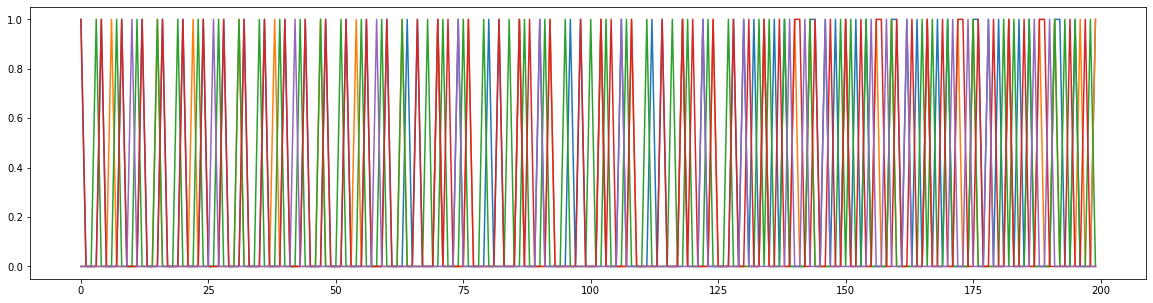

In [6]:
figsize(20,5)
plot(tracks[35][:200])
plot(tracks[37][:200])
plot(tracks[42][:200])
plot(tracks[44][:200])
plot(tracks[46][:200])
lim=1000
seqMatrix = array([tracks[35][:lim],tracks[37][:lim],tracks[42][:lim],tracks[44][:lim],tracks[46][:lim]])

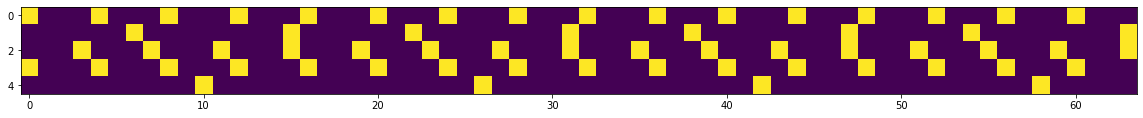

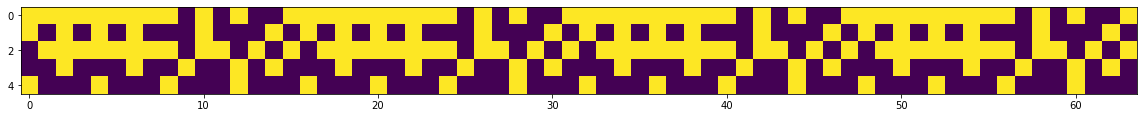

In [8]:
figsize(20,5)
figure(1)
imshow(seqMatrix[:,:64])
figure(2)
imshow(seqMatrix[:,512-64:512])

In [9]:

def ttable_gen_linrand():
    return random.randint(2, size=16)

def ttable_gen_sparse1():
    x = zeros(16, dtype=int)
    x[random.randint(16)] = 1
    return x

    
def makeLUT4(inputs, layer, idx, ttable_gen=ttable_gen_linrand):
    lut4 = {'layer':layer, 'idx':idx, 'out':0, 'ttable':ttable_gen(), 'netIn':inputs}
    return lut4


def byteToBits(val, bitCount):
    return [int(val & (1 << (bitCount-x-1)) > 0) for x in range(bitCount)]

def bitsToInt(bits):
    return sum([x * pow(2,len(bits)-i-1) for i,x in enumerate(bits)])

def calcNet(lutnet):
    for layer in lutnet[1:]:
        calcLayer(layer)
        
hamming4bit = []
for i in range(16):
    dists = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
    for j in range(16):
        dists[j] = distance.hamming(byteToBits(i, 4), byteToBits(j,4))
    hamming4bit.append(dists)
        

byteToBits4Table = [byteToBits(x,4) for x in range(16)]
def byteToBits4(x):
    return byteToBits4Table[x]
byteToBits4(7)


[0, 1, 1, 1]

In [10]:
def dataToBinary(data, base=8):
    xmin = np.min(data[:,0])
    xmax = np.max(data[:,0])    
    quantData = [[np.round(np.interp(x[0],[xmin, xmax],[0,pow(2,base)-1]))] for x in data]
    return np.array([byteToBits(int(x[0]), base) for x in quantData])


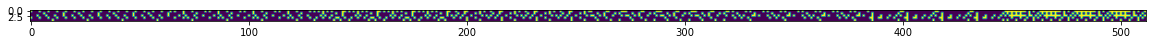

In [12]:
imshow(seqMatrix[:,:])

In [13]:
seqMatrix.shape

(5, 512)

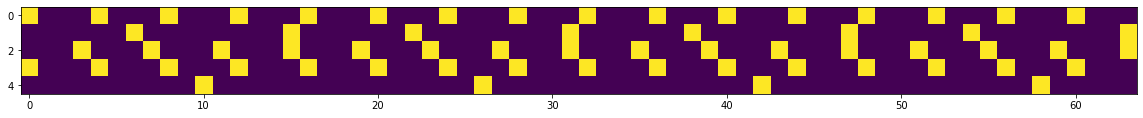

In [15]:
imshow(seqMatrix[:,:64])

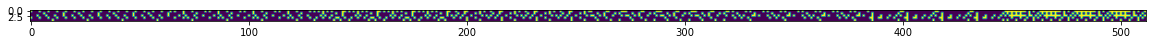

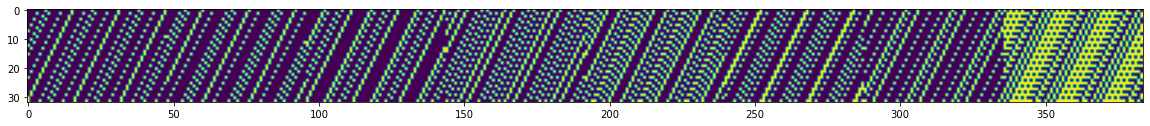

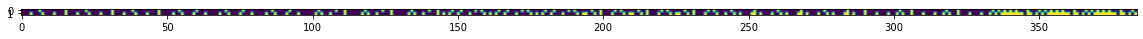

In [16]:
def createTrainingData(seq, sourceChannels = [0], predictionChannels=[0]):
    #take a sliding window across each group
    slidingWindowSteps = 16
    numSourceChannels = len(sourceChannels)
    totalSteps=seq.shape[1] - slidingWindowSteps
    x = zeros((totalSteps, slidingWindowSteps * numSourceChannels), dtype=int)
    y = zeros((totalSteps, len(predictionChannels)), dtype=int)
    for i in range(totalSteps):
        for j in range(slidingWindowSteps):
            pos = j * numSourceChannels
            x[i,pos:pos+numSourceChannels] = seq[sourceChannels,i+j]
        y[i] = seq[predictionChannels,i+slidingWindowSteps]
    return x,y

def compileTrainingSet(sourceChannels = [0], predictionChannels=[0]):
    subseqs = [createTrainingData(seqMatrix[:,i*64:(i+1)*64], sourceChannels, predictionChannels) for i in range(8)]
    inseq = np.concatenate([x[0] for x in subseqs])
    outseq = np.concatenate([x[1] for x in subseqs])
    return inseq, outseq

inseq, outseq = compileTrainingSet([1,2],[1,2])
figure(1)
imshow(seqMatrix)
figure(2)
imshow(inseq.T)
figure(3)
imshow(outseq.T)

In [20]:
from sklearn.model_selection import train_test_split


def oneHot(v):
    outs = zeros(numClasses, dtype=int)
    outs[v] = 1
    return list(outs)

def evalExample(targetOutput, netOut):
    expectedOutput = targetOutput
    testResults = [1 if netOut[i] == x else 0 for i,x in enumerate(expectedOutput)]
    score = 1 if sum(testResults) == len(testResults) else 0
    nodeCorrections = [1 if netOut[i] == x else 0 for i,x in enumerate(expectedOutput)]
    trainOnThis = True
    return [score, nodeCorrections, trainOnThis]


def selectTrainingSet(evalResults):
    psves = [x for x in evalResults if x[0] == 1]
    negs = [x for x in evalResults if x[0] == 0]
    smallest = min (len(psves), len(negs))
    psveProb = 0 if len(psves)== 0 else smallest / len(psves)
    negProb = 0 if len(negs) == 0 else smallest / len(negs)
    for i,x in enumerate(evalResults):
        if (evalResults[i][0] == 0):
            evalResults[i][2] = random.random() < negProb
        else:
            evalResults[i][2] = random.random() < psveProb
    return evalResults


    
def createTrainingSet(allDataIn, allDataOut, testSize=0.2):
    x_train, x_test, y_train, y_test = train_test_split(allDataIn, allDataOut, test_size=testSize)
    return {'in':x_train, 'out':y_train, 
            'testin': x_test, 'testout': y_test, 
            'eval':evalExample,
            'selector': selectTrainingSet
           }

inseq, outseq = compileTrainingSet([0],[0])
trainingSet = createTrainingSet(inseq, outseq)

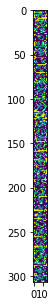

In [22]:
figsize(20,5)
imshow(trainingSet['in'][:])

In [23]:
trainingSet['in'].shape

(307, 16)

In [27]:
from enum import Enum
class initSchemes(Enum):
    LINRAND= 0
    ZEROS = 1
    SPARSE = 2
    
def createNet(inSize, layerSizes, initScheme = initSchemes.LINRAND, lowProbLayers=[]):
    testNet = lutnet.FFLUT4Net(inSize)
    for v in layerSizes:
        testNet.addLayer(v)
    if (initScheme != initSchemes.LINRAND):
        #leave the top layer as linrand
        for i_layer in range(testNet.getLayerCount()-1):
            if i_layer not in lowProbLayers:
                for i_node in range(testNet.getLayerSize(i_layer)):
                    for i_ttable in range(16):
                        testNet.setTtableElement(i_layer, i_node, i_ttable, 0)
                    if (initScheme == initSchemes.SPARSE):
                        testNet.setTtableElement(i_layer, i_node, np.random.randint(16), 1)
        
    return testNet
inSize = len(trainingSet['in'][0])
layerStructure = [8,4,1]
testNet = createNet(4,layerStructure, initSchemes.SPARSE, lowProbLayers=[])

In [28]:
layerSizeMax = max([testNet.getLayerSize(x) for x in range(testNet.getLayerCount())])
print(layerSizeMax)
G = nx.DiGraph()
def nodeName(layer,idx):
    return "L{}N{}".format(layer,idx)
    return (layer,idx)
posDict = {}
labelsDict={}
nodesMap = []
for i_layer in range(testNet.getLayerCount())[1:]:
    for i_node in range(testNet.getLayerSize(i_layer)):
        for i_inNode in range(4):
            inNodeIdx = testNet.getInputIndex(i_layer,i_node,i_inNode)
            inNodeName = nodeName(i_layer-1,inNodeIdx)
            
            outNodeName = nodeName(i_layer, i_node)
            edge = (inNodeName, outNodeName)
            G.add_edge(*edge)
            yOffset = (layerSizeMax - testNet.getLayerSize(i_layer)) /2 
            posDict[outNodeName] = array([i_layer, yOffset + i_node])
            
            if (inNodeName not in posDict):
                yOffset = (layerSizeMax - testNet.getLayerSize(i_layer-1)) /2 
                posDict[inNodeName] = array([i_layer-1, yOffset + inNodeIdx], dtype=float)
    
            

8


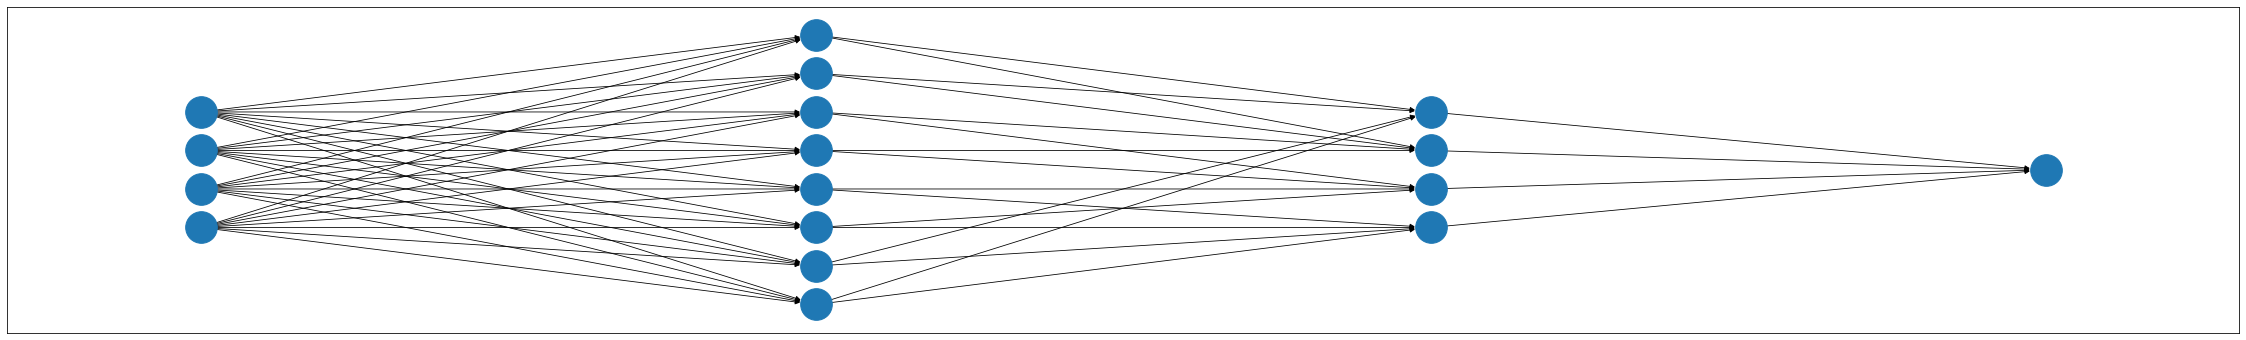

In [67]:
figsize(40,6)
nx.draw_networkx(G, pos=posDict,with_labels=False, width=0.8,node_size=1000)
plt.savefig("lutnet.png")
None

In [29]:
import copy
def findLayerClusters(lutnet, layer, nodes):
    clusterList = []
    clusterTemplate = {'outputNodes':[], 'inputNodes':[]}
    def makeNewCluster(topNode):
        newCluster = copy.deepcopy(clusterTemplate)
        newCluster['outputNodes'] = [topNode]
        for i_input in range(4):
            newCluster['inputNodes'].append(lutnet.getInputIndex(layer, topNode,i_input))
        return newCluster
        
    for i_toplayer in nodes:
        if len(clusterList) == 0:
            clusterList = [makeNewCluster(i_toplayer)]
        else:
            foundCluster = None
            for i_input in range(4):
                inNodeIdx = lutnet.getInputIndex(layer, i_toplayer, i_input)
                for cluster in clusterList:
                    if inNodeIdx in cluster['inputNodes']:
                        foundCluster = cluster
                        break
                if foundCluster != None:
                    break
            if foundCluster != None:
                #add to current cluster
                cluster['outputNodes'].append(i_toplayer)
                for i_input in range(4):
                    inputNodeIdx = lutnet.getInputIndex(layer, i_toplayer,i_input)
                    if inputNodeIdx not in cluster['inputNodes']:
                        cluster['inputNodes'].append(inputNodeIdx)
            else:
                #make a new cluster
                clusterList.append(makeNewCluster(i_toplayer))
            

    return clusterList


def splitIntoBatches(x, batchSize):
    rem = x.shape[0] % batchSize
    dim1 = x.shape[0]-rem
    batches1 = list(x[:dim1].reshape(int(dim1/batchSize),batchSize))
    batches2 = x[-rem:]
    batches1[len(batches1)-1] = np.concatenate((batches1[len(batches1)-1], batches2))
    return batches1


def genStruct(depth, numclasses, topLayerIndependence=2):
    st = [numclasses]
    v = numclasses
    print(st)
    for i in range(depth):
        v *= 4 if i < topLayerIndependence else 2
        st.append(v)
    st.reverse()
    return st


In [30]:
#this is the new version that trains by layer instead of node
#inputs: network, training pair
#output: list of ttable entries to change and testresult for this training pair
def trainingStep(lutnet, testResults, config, layerDepth):
    
    def processLayer(layerIdx, incorrectNodes):
        layerClusters = findLayerClusters(lutnet, layerIdx, incorrectNodes)
        
        nodeTtableChanges = []
        nodeTtableProtections = []
        
        stats = {}
        stats['comboMissCount'] = 0
        stats['noCompatCount'] = 0
        stats['ruleAddition'] =0

        

        for cl in layerClusters:
#             print("Processing cluster: ", cl)
            #find ttable options for each node and check for compatible options
            #if there are compatible options, then choose the one that needs minimum change
            #if there are no compatible options, do something else, but what? (definitely do something or risk stalling)
            changeCandidateLists = {}
            for nodeIdx in cl['outputNodes']:
                ttable = [lutnet.getTtableElement(layerIdx, nodeIdx, x) for x in range(16)]
                #find ttable entries that would be correct, if given correct input
                targetResult = lutnet.getOutput(layerIdx,nodeIdx)
                if (nodeIdx in incorrectNodes):
                    targetResult = 1 - targetResult
                
                LUTChangeCandidates = [i for i,x in enumerate(ttable) if x == targetResult]
                
                changeCandidateLists[nodeIdx] = LUTChangeCandidates
            #for all poss combos of candidates
            changeCombos = [changeCandidateLists[x] for x in changeCandidateLists]
            for v in changeCombos:
                random.shuffle(v)

            
            inputMappings = [[lutnet.getInputIndex(layerIdx, nodeIdx,x) for x in range(4)] for nodeIdx in cl['outputNodes']]
            compatibleChangeCandidates = []
            i_combo=0
            for combo in itertools.product(*changeCombos):
                i_combo+=1
                #stack up the bits
                #do they all match? if so, add this combo to list (change candidates and bit pattern)
                bitstacks = {}
                for i_node,v in enumerate(combo):
                    ttableEntryBits = byteToBits4(v)
                    for i_bit, ttableBit in enumerate(ttableEntryBits):
                        bitSource = inputMappings[i_node][i_bit]
                        if bitSource in bitstacks:
                            bitstacks[bitSource] += ttableBit
                        else:
                            bitstacks[bitSource] = ttableBit

                #check for compatibility
                compatible = True
                numNodes = len(cl['outputNodes'])
                #was the bitstack either all zeros or all ones?
                for v in bitstacks:
                    if not (bitstacks[v] ==0 or bitstacks[v] == numNodes):
                        compatible = False
                        break
                bitpattern = [1 if bitstacks[x] > 0 else 0 for x in bitstacks]
                if compatible:
                    compatibleChangeCandidates.append([combo, bitpattern, bitstacks])
                if (i_combo >= config['COMBO_LIMIT']):
                    stats['comboMissCount'] += 1
                    break

            if len(compatibleChangeCandidates) > 0:
                #input state for all nodes in the cluster
                inputState = [lutnet.getOutput(layerIdx-1,x) for x in cl['inputNodes']]
                distancesToChangeCandidates = array([distance.hamming(inputState, x[1]) for x in compatibleChangeCandidates])
                minDist = min(distancesToChangeCandidates)
                minDistIdxs = [i for i,x in enumerate(distancesToChangeCandidates) if x <= minDist]
                indexChoice = np.random.choice(minDistIdxs)
                comboChoice = compatibleChangeCandidates[indexChoice]
#                 print("Input: ", inputState, ", modification: ", comboChoice)
                #which nodes should be changed base on current rule of input nodes?
                for i_innode, v in enumerate(comboChoice[2]):
                    curInputVal = lutnet.getOutput(layerIdx-1,v)
                    targetInputVal = 1 if comboChoice[2][v] > 0 else 0
                    nodeInputIndexes =[lutnet.getInputIndex(layerIdx-1, v, x) for x in range(4)]
                    nodeInputState = [lutnet.getOutput(layerIdx-2,x) for x in nodeInputIndexes]
                    rule = bitsToInt(nodeInputState)
                    if (config['RANDOM_VAL_CHOICE']==True):
                        rule = np.random.randint(16)
                        targetInputVal = np.random.randint(2)
                    if targetInputVal != curInputVal:
                        nodeTtableChanges.append({'layer': layerIdx-1, 'nodeIdx':v, 'rule':rule, 'val':targetInputVal})
                    else:
                        nodeTtableProtections.append({'layer': layerIdx-1, 'nodeIdx':v, 'rule':rule, 'val':targetInputVal})
        
        return nodeTtableChanges, nodeTtableProtections, stats
        
    nodeChanges = []
    nodeProtections = []
    changeList = []
    topLayer = lutnet.getLayerCount() -1
    incorrectNodes = [i for i,x in enumerate(testResults) if x == 0]
    stats = {}
    #choose how deep to go in node changes
    for layer in range(layerDepth):
        nodeChanges, nodeProtections, layerStats = processLayer(topLayer - layer, incorrectNodes)

        incorrectNodes = np.unique([x['nodeIdx'] for x in nodeChanges])

        for key in layerStats:
            if not key in stats:
                stats[key] = 0
            stats[key] += layerStats[key]

    
    return nodeChanges, nodeProtections, stats


In [31]:
import copy
class reRandSchemes(Enum):
    NONE=0
    TOPLAYER=1
    BOTTOMLAYER=2

class layerChoice(Enum):
    RANDOM_LOG=0
    CYCLIC=1
    RANDOM_LIN=2

class layerChoicePoint(Enum):
    DATASET=0
    BATCH=1

def trainNetwork(iterations, ts, batchErrorLog, config, layerLog, modelIdx):
    def splitIntoBatches(x, batchSize):
        rem = x.shape[0] % batchSize
        dim1 = x.shape[0]-rem
        batches1 = list(x[:dim1].reshape(int(dim1/batchSize),batchSize))
        batches2 = x[-rem:]
        batches1[len(batches1)-1] = np.concatenate((batches1[len(batches1)-1], batches2))
        return batches1
    minerror = 999
    visDebug = 0
    if config['STARTING_MODEL'] == None:
        net = createNet(len(ts['in'][0]), config['LAYERS'], config['INITSCHEME'], [])
    else:
        net = config['STARTING_MODEL']
    trainSize=len(ts['in'])
    trainLength = iterations

    if visDebug:
        figsize(20,50)
        fig, axes = plt.subplots(nrows=trainLength, ncols=4)
        ax = axes.flatten()

    idx=0
    graphIdx=0
    batchSize = config['BATCHSIZE']
    outputLayerSize = net.getLayerSize(net.getLayerCount()-1)
    minError = 1
    lastError = 1.0
    finished=0
    shuffledIndexes = arange(len(ts['in']))
    np.random.shuffle(shuffledIndexes)
    batches = splitIntoBatches(shuffledIndexes, batchSize)
    changeListLengths = []
    noiseProb = 0
    lastNoise=0
    bestModel = 0
    lastModel = 0
    trainStats = []
    def chooseLayerDepth():
        layerIndexes = arange(net.getLayerCount()-2) + 1
        layerIndexes = np.setdiff1d(layerIndexes, config['FIXED_LAYERS'])

            
        if (config['LAYER_CHOICE'] == layerChoice.CYCLIC):
            layerDepth = layerIndexes[i % len(layerIndexes)]
        else:
            if (config['LAYER_CHOICE'] == layerChoice.RANDOM_LIN):
                layerDepth = np.random.choice(layerIndexes)
            else:
                #RANDOM_LOG
                layerProbs = layerIndexes / sum(layerIndexes)
                layerDepth = np.random.choice(layerIndexes,1,p=layerProbs)[0]
        return layerDepth
    lastMinIdx=0
    for i in range(trainLength):
        trainingScore =0.0
        layerProbCurve=1.0
        if (i%2==0):
            print(f'model {modelIdx}, i {i}, {minError}')

        if (config['RESHUFFLE_BATCHES'] == True):
            np.random.shuffle(shuffledIndexes)
            batches = splitIntoBatches(shuffledIndexes, batchSize)
            
        if (config['LAYER_CHOICE_POINT'] == layerChoicePoint.DATASET):
            layerDepth = chooseLayerDepth()
        stepStats = {}
        for batch in batches:
            if (config['LAYER_CHOICE_POINT'] == layerChoicePoint.BATCH):
                layerDepth = chooseLayerDepth()
            changeListAll = []
            keepListAll = []
            batchError = 0
            

            def calcNet(trainIndex):
                state = ts['in'][trainIndex]
                net.calc(state)
                netOutput = [net.getTopLayerOutput(i) for i in range(outputLayerSize)]
                return netOutput

            def trainOneExample(trainIndex, nodeCorrections):
                netOutput = calcNet(trainIndex)
                changeList, keepList, exampleStats = trainingStep(net, nodeCorrections, config, layerDepth)
                for key in exampleStats:
                    if not key in stepStats:
                        stepStats[key] = 0
                    stepStats[key] += exampleStats[key]

                return array(nodeCorrections), changeList, keepList
            
                
            batchOutputs = [calcNet(x) for x in batch]
            batchEvals = [ts['eval'](ts['out'][x], batchOutputs[i]) for i,x in enumerate(batch)]
            if config['SELECTOR']:
                batchEvals = ts['selector'](batchEvals)
            batchChanges = [trainOneExample(x, batchEvals[i][1]) for i,x in enumerate(batch) if batchEvals[i][2] == True]

            numChanges=0
            avgTestRes = 0
            for res in batchChanges:
                testRes, changeList, keepList = res
                changeListAll.append(changeList)
                keepListAll.append(keepList)
            avgTestRes = np.mean([x[0] for x in batchEvals]) 
            batchError = 1.0 - avgTestRes
            lastError = batchError
            batchErrorLog.append(batchError)
            errorChecking = len(batchErrorLog) > len(batches)
            runningError = 1
            if errorChecking:
                runningError = mean(batchErrorLog[:-len(batches)])
                if (batchError <= minError):
                    minError = batchError
                    lastMinIdx=i
                    print("m{} {}\tmin:{} ({})".format(modelIdx, i, minError, runningError))
                    bestModel = pickle.dumps(net)
            
            if (runningError<= config['STOP_CONDITION']):
                finished=1
                break;
            else:
                if len(changeListAll) > 0:
                    #apply batch changes
                    changeFreqTable = {}
                    def makeHash(layer, node, rule):
                        # [16 bit layer][32 bit node][4 bit rule]
                        layer = (layer & 65535) << 36
                        node = ((node &  4294967295) << 4)
                        rule = (rule & 15)
                        return layer | node | rule
                    def hashToAddress(hash):
                        return [hash >> 36, (hash >> 4) & 4294967295, hash & 15]
                    if (config['POPULARITY'] > 0):
                        for changes in changeListAll:
                            for c in changes:
                                hash = makeHash(c['layer'], c['nodeIdx'], c['rule'])
                                if hash not in changeFreqTable:
                                    changeFreqTable[hash] = [0,0]
                                changeFreqTable[hash][c['val']]+=1
                        if (config['KEEP_LIST'] == True):
                            for changes in keepListAll:
                                for c in changes:
                                    hash = makeHash(c['layer'], c['nodeIdx'], c['rule'])
                                    if hash not in changeFreqTable:
                                        changeFreqTable[hash] = [0,0]
                                    changeFreqTable[hash][c['val']]+=1
                        changeMags = [] #zeros(len(changeFreqTable))
                        for i_hash,hash in enumerate(changeFreqTable):
                            changeMag = max(changeFreqTable[hash])
                            if (changeMag > 0):
                                changeMags.append(changeMag)
                        if (len(changeMags) > 0):
                            popularity = config['POPULARITY']
                            if config['VAR_POP']==True:
                                errorStd = std(batchErrorLog[-30:]) + 0.000001
                                popularity = interp(log(errorStd),[-5,-2],[0.4,0.95])
                            changeThresh = np.quantile(changeMags, popularity)
                            for hash in changeFreqTable:
                                changeVal = changeFreqTable[hash]
                                mag = max(changeVal)
                                if mag >= changeThresh:
                                    address = hashToAddress(hash)
                                    val = 0 if changeVal[0] > changeVal[1] else 1
                                    net.setTtableElement(address[0], address[1], address[2], val)
                    else:
                        for changes in changeListAll:
                            for c in changes:
                                net.setTtableElement(c['layer'], c['nodeIdx'], c['rule'],c['val'])
    

                            
        if (stepStats != {}):
            trainStats.append(stepStats)    
        if finished:
            break
    lastModel = pickle.dumps(net)
    return bestModel, lastModel, trainStats
            



In [34]:
def testOnData(net, dataIn, dataOut, evalFunction):
    score=0
    outputLayerSize=net.getLayerSize(net.getLayerCount()-1)
    for i,t in enumerate(dataIn):
        net.calc(t)
        result = [net.getTopLayerOutput(x) for x in range(outputLayerSize)]
        itemScore = evalFunction(dataOut[i], result)[0]
        score += itemScore
    score = score/len(dataIn) * 100
    return score

In [ ]:
# %%time
import random as pyrand


structs = [
        [128,64,16,4,1],
        [512,256,64,16,4,1],
        [2048,1024,256,64,16,4,1],
]


@ray.remote    
def trainANetwork(i_test, sources, targets):
    starttime = datetime.now().timestamp()
    structIdx = np.random.randint(len(structs))
    testConfig={'LAYERCHOICE':'LOG', #or LOG 
                'BATCHSIZE':int(random.choice([1.0]) * len(trainingSet['in'])),
                'STRUCT':structIdx,
                'LAYERS':np.array(structs[structIdx]) * len(targets),
                'FIXED_LAYERS':[],
                'LAYER_CHOICE_POINT': layerChoicePoint.BATCH,
                'RESHUFFLE_BATCHES': True,
                 'INITSCHEME': initSchemes.SPARSE,
                'STARTING_MODEL':None,
                'STOP_CONDITION': 0.00,
                'COMBO_LIMIT': 99999,
                'LAYER_CHOICE': layerChoice.RANDOM_LOG,
                'RANDOM_VAL_CHOICE':False,
                'POPULARITY':0.90,
                'KEEP_LIST':True,
                'SELECTOR': False,
                'VAR_POP': False,
               }   
    inseq, outseq = compileTrainingSet(sources, targets)
    ts = createTrainingSet(inseq, outseq)
    logging.info("config %s", testConfig)
    print("=======Test: ",i_test, "config: ", testConfig)
    errorLog = []
    layerLog = []
    bestModelPickled, lastModelPickled, trainStats = trainNetwork(300, ts, errorLog, testConfig, layerLog, i_test)
    endtime = datetime.now().timestamp()
    print("=======Test complete: ",i_test, "config: ", testConfig)
    print('log: ', min(errorLog), ', ', len(errorLog))
    def testModel(mod, trainSet):
        trainscore = testOnData(mod, trainSet['in'], trainSet['out'], trainSet['eval'])
        print(i_test, " Training Data Score:",trainscore, "%")
        testscore = testOnData(mod, trainSet['testin'], trainSet['testout'], trainSet['eval'])
        print(i_test, " Test Data Score:",testscore, "%")
        return trainscore, testscore
    print("Best model results:")
    bestModel = pickle.loads(bestModelPickled)
    trainscore, testscore = testModel(bestModel, ts)
    result ={'layerLog': layerLog, 'modelPickled': bestModelPickled, 'finalModelPickled': 
             lastModelPickled, 'log':errorLog, 'stats':trainStats, 'cfg':testConfig, 
             'trainDataScore':trainscore, 
             'testDataScore':testscore, 
             'time':endtime - starttime,
             'inseq':inseq,
             'outseq':outseq,
             'sources':sources,
             'targets':targets,
            'ts':ts}
    return result

def trainOnPatterns(sources, targets):
    tres = []
    parallelCount = 20
    futures = [trainANetwork.remote(x, sources, targets) for x in range(parallelCount)]
    tres = ray.get(futures)
    print("Done")
    return tres

booscResults = []
predictionTasks = [([0],[0]), ([1],[1]), ([3],[3]), ([0,1],[2]), ([0,1],[3]), 
                   ([1,2],[4]), ([1,3],[4]), ([0],[1]), ([1],[2]), ([1],[4]),
                   ([0],[3,4]), ([2],[3,4]), ([3],[0,1]), ([2],[3,4]),
                   ([0,1],[2,3]), ([0,1,2],[3,4]),
                   ([4],[1]), ([3],[2]), ([4,1],[0]), ([3,2],[4])
                  ]
filename = datetime.now().strftime("%m%d%Y_%H%M%S") + 'booscresults2.picked'
for p in predictionTasks:
    print("New expt: ", p)
    tres = trainOnPatterns(p[0], p[1])
    bestResultIdx  =argmax([x['testDataScore'] for x in tres])
    bestResult = tres[bestResultIdx]
    if bestResult['testDataScore']==100:
        highScorers = [x for x in tres if x['testDataScore']==100]
        bestResultIdx  =argmin([x['cfg']['STRUCT'] for x in highScorers])
        bestResult = highScorers[bestResultIdx]
        
    booscResults.append(bestResult)
    bestResult['ts']['eval'] = None
    bestResult['ts']['selector'] = None
    with open(filename, 'wb') as handle:
        pickle.dump(booscResults,handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
tres[0]['ts']['eval'] = None
tres[0]['ts']['selector'] = None

import ipynbname
import pickle

filename = 'tres/' + ipynbname.name() + '.tres.pickle'
print(filename)
with open(filename, 'wb') as handle:
    pickle.dump(tres[0],handle, protocol=pickle.HIGHEST_PROTOCOL)


In [40]:
#use the filename of the saved results
with open('xxxxxxxx.pickled', 'rb') as handle:
    booscRes = pickle.load(handle)


In [41]:
[(i,x['testDataScore'], x['cfg']['LAYERS']) for i,x in enumerate(booscRes)]

[(0, 100.0, array([128,  64,  16,   4,   1])),
 (1, 100.0, array([128,  64,  16,   4,   1])),
 (2, 100.0, array([128,  64,  16,   4,   1])),
 (3, 77.92207792207793, array([128,  64,  16,   4,   1])),
 (4, 84.4155844155844, array([512, 256,  64,  16,   4,   1])),
 (5, 100.0, array([512, 256,  64,  16,   4,   1])),
 (6, 100.0, array([2048, 1024,  256,   64,   16,    4,    1])),
 (7, 93.5064935064935, array([2048, 1024,  256,   64,   16,    4,    1])),
 (8, 79.22077922077922, array([2048, 1024,  256,   64,   16,    4,    1])),
 (9, 97.40259740259741, array([2048, 1024,  256,   64,   16,    4,    1])),
 (10, 79.22077922077922, array([256, 128,  32,   8,   2])),
 (11, 75.32467532467533, array([256, 128,  32,   8,   2])),
 (12, 80.51948051948052, array([4096, 2048,  512,  128,   32,    8,    2])),
 (13, 80.51948051948052, array([4096, 2048,  512,  128,   32,    8,    2])),
 (14, 59.74025974025974, array([256, 128,  32,   8,   2])),
 (15, 90.9090909090909, array([4096, 2048,  512,  128,   32,

# GA

In [44]:
def evoCalcNet(net,state):
    net.calc(state)
    netOutput = [net.getTopLayerOutput(i) for i in range(net.getLayerSize(net.getLayerCount()-1))]
    return netOutput

def setTTables(net, vals):
    idx=0
    for layer in range(1,net.getLayerCount()):
        for node in range(net.getLayerSize(layer)):
            for ttableIdx in range(16):
                net.setTtableElement(layer, node, ttableIdx, vals[idx])
                idx += 1
    if (idx != len(vals)):
        print("Set ttables: length mismatch")


In [45]:
brIdx=0
evoStruct = booscRes[brIdx]['cfg']['LAYERS']
print(evoStruct)
indSize = sum(evoStruct) * 16
print(indSize)

[128  64  16   4   1]
3408


In [36]:
from deap import base, creator
from deap import tools
# import multiprocessing


creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)
toolbox = base.Toolbox()
# pool = multiprocessing.Pool()
# toolbox.register("map", pool.map)


In [42]:
def testIndividual(ind, brIdx):
    print("Test data score ",  brIdx)
    evoStruct = booscRes[brIdx]['cfg']['LAYERS']
    evonet = createNet(len(booscRes[brIdx]['ts']['in'][0]), evoStruct)
    print("struct ", evoStruct)
    setTTables(evonet, ind)
    score = testOnData(evonet, booscRes[brIdx]['ts']['testin'], booscRes[brIdx]['ts']['testout'], evalExample)    
    error = 1.0 - (score / 100)
    return error



In [ ]:
def evomain(CXPB=0.1, MUTPB=0.1, popsize=50):
    # CXPB  is the probability with which two individuals
    #       are crossed
    #
    # MUTPB is the probability for mutating an individual
    pop = toolbox.population(n=popsize)
    fitnesses = list(map(toolbox.evaluate, pop))
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit    
    fits = [ind.fitness.values[0] for ind in pop]
    g = 0
    
    # Begin the evolution
    while min(fits) > 0 and g < 1000:
        # A new generation
        g = g + 1
        print("-- Generation %i --" % g)    
        offspring = toolbox.select(pop, len(pop))
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < CXPB:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < MUTPB:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
        pop[:] = offspring
        # Gather all the fitnesses in one list and print the stats
        fits = [ind.fitness.values[0] for ind in pop]
        
        length = len(pop)
        mean = sum(fits) / length
        sum2 = sum(x*x for x in fits)
        std = abs(sum2 / length - mean**2)**0.5
        
        print("  Mi/ma/av/st ", min(fits),max(fits),mean,std)

    best_ind = tools.selBest(pop, 1)[0]
    print("Best individual is %s" % (best_ind.fitness.values))
    return best_ind   


def testEvo(runIdx, brIdx):
    print("Run ", runIdx, 'expt ', brIdx)
    booscRes[brIdx]['ts']['eval'] = evalExample
    evoStruct = booscRes[brIdx]['cfg']['LAYERS']
    evonet = createNet(len(booscRes[brIdx]['ts']['in'][0]), evoStruct)
    indSize = sum(evoStruct) * 16
    print("struct ", evoStruct)
    print("indSize ", indSize)
    def evalOneMin(individual):
        setTTables(evonet,individual)
        score = testOnData(evonet, booscRes[brIdx]['ts']['in'], booscRes[brIdx]['ts']['out'], booscRes[brIdx]['ts']['eval'])    
        error = 1.0 - (score / 100)
        return error,

    # Attribute generator 
    def sparseBool():
        return 1 if random.random() < 0.1 else 0
    toolbox.register("attr_bool", sparseBool)
#     toolbox.register("attr_bool", random.randint, 0, 2)
    
    # Structure initializers
    toolbox.register("individual", tools.initRepeat, creator.Individual, 
    toolbox.attr_bool, indSize)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", evalOneMin)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    bestInd = evomain(0.1,0.1,50)
    return bestInd



def runExpt(brIdx):
    print("Expt ", brIdx)
    evoRes = [testEvo(x, brIdx) for x in range(10)]

    testDataScores = [testIndividual(x,brIdx) for x in evoRes]
    print("test scores: ", testDataScores)
    bestRun = argmin(testDataScores)
    bestEvo = evoRes[bestRun]
    return bestEvo

def runAllEvoExpts():
    evofilename = datetime.now().strftime("%m%d%Y_%H%M%S") + 'evoresults.picked'
    evoResults = []
#     for i in range(1):
    for i in range(len(booscRes)):
        res = runExpt(i)
        evoResults.append(res)
        with open(evofilename, 'wb') as handle:
            pickle.dump(evoResults,handle, protocol=pickle.HIGHEST_PROTOCOL)
    return evoResults

allEvoRes = runAllEvoExpts()

        

In [47]:
with open('xxxx my results file.picked', 'rb') as handle:
    evoRes = pickle.load(handle)

In [48]:
testIndividual(evoRes[19],19)

Test data score  19
struct  [2048 1024  256   64   16    4    1]


0.06493506493506507

# Memorisation

In [ ]:
def makeHisto4():
    return zeros((16,2), dtype=int)
makeHisto4()

In [ ]:

def trainLayerByMemz(net, layer, ts):
    layerSize = net.getLayerSize(layer)
    print("layer size", layerSize)
    histos = [makeHisto4() for x in range(layerSize)]
    targetLen = len(ts['out'][0])
    #collect frequency data
    for tr in range(len(ts['in'])):
#         print(ts['in'][tr], trainTarget)
        net.calc(ts['in'][tr])
        for nodeIdx in range(layerSize):
            trainTargetIndex = int(floor(nodeIdx / layerSize * targetLen) )
#             print(trainTargetIndex, targetLen)
            trainTarget = ts['out'][tr][trainTargetIndex]
            nodeAddr = net.calcNodeLUTAddress(layer, nodeIdx)
            histos[nodeIdx][nodeAddr][trainTarget] += 1
    #apply histograms to calculate truth tables
    for nodeIdx in range(layerSize):
        freqTable = histos[nodeIdx]
#         print(freqTable)
        for ttableIdx in range(16):
            ttableValue=0
            if freqTable[ttableIdx][0] > freqTable[ttableIdx][1]:
                ttableValue = 0
            elif freqTable[ttableIdx][0] < freqTable[ttableIdx][1]:
                ttableValue = 1
            else:
                ttableValue = 1 if random.random() >= 0.5 else 0
            net.setTtableElement(layer, nodeIdx, ttableIdx, ttableValue)
#             print(ttableIdx, ttableValue)
    #test        
    score=0
    for tr in range(len(ts['in'])):
        trainTarget = ts['out'][tr][0]
        net.calc(ts['in'][tr])
        trainItemScore=0
        for nodeIdx in range(layerSize):
            nodeOut = net.getOutput(layer,nodeIdx)
            if (nodeOut == trainTarget):
                trainItemScore+=1
        trainItemScore /= layerSize
#         print(trainItemScore)
        score += trainItemScore
    score /= len(ts['in'])
    print(score)
    return score
       
memzResults = []

# for brIdx in [10]:
for brIdx in range(20):
    booscRes[brIdx]['ts']['eval'] = evalExample
    chStruct = booscRes[brIdx]['cfg']['LAYERS']
#     if (chStruct[-1] == 1):
    memznet = createNet(len(booscRes[brIdx]['ts']['in'][0]), chStruct)    
    score=0
    for layer in range(len(chStruct)):
        score =trainLayerByMemz(memznet,layer+1,booscRes[brIdx]['ts'])
    testScore = testOnData(memznet, booscRes[brIdx]['ts']['testin'], booscRes[brIdx]['ts']['testout'], evalExample)    

    memzResults.append({'idx':brIdx,'trainScore':score, 'testScore':testScore})



In [ ]:
with open('memzresults.pickled', 'wb') as handle:
    pickle.dump(memzResults,handle, protocol=pickle.HIGHEST_PROTOCOL)

In [52]:
with open('./memzresults.pickled', 'rb') as handle:
    memzRes = pickle.load(handle)


In [53]:
memzRes

[{'idx': 0, 'trainScore': 1.0, 'testScore': 100.0},
 {'idx': 1, 'trainScore': 1.0, 'testScore': 100.0},
 {'idx': 2, 'trainScore': 1.0, 'testScore': 100.0},
 {'idx': 3, 'trainScore': 0.8631921824104235, 'testScore': 80.51948051948052},
 {'idx': 4, 'trainScore': 0.8697068403908795, 'testScore': 85.71428571428571},
 {'idx': 5, 'trainScore': 0.9315960912052117, 'testScore': 92.20779220779221},
 {'idx': 6, 'trainScore': 0.9446254071661238, 'testScore': 90.9090909090909},
 {'idx': 7, 'trainScore': 0.9609120521172638, 'testScore': 92.20779220779221},
 {'idx': 8, 'trainScore': 0.7947882736156352, 'testScore': 64.93506493506493},
 {'idx': 9, 'trainScore': 0.8925081433224755, 'testScore': 88.31168831168831},
 {'idx': 10, 'trainScore': 0.755700325732899, 'testScore': 71.42857142857143},
 {'idx': 11, 'trainScore': 0.7638436482084691, 'testScore': 66.23376623376623},
 {'idx': 12,
  'trainScore': 0.7638436482084691,
  'testScore': 53.246753246753244},
 {'idx': 13, 'trainScore': 0.7931596091205212, '

Test data score  0
struct  [128  64  16   4   1]
Test data score  1
struct  [128  64  16   4   1]
Test data score  2
struct  [128  64  16   4   1]
Test data score  3
struct  [128  64  16   4   1]
Test data score  4
struct  [512 256  64  16   4   1]
Test data score  5
struct  [512 256  64  16   4   1]
Test data score  6
struct  [2048 1024  256   64   16    4    1]
Test data score  7
struct  [2048 1024  256   64   16    4    1]
Test data score  8
struct  [2048 1024  256   64   16    4    1]
Test data score  9
struct  [2048 1024  256   64   16    4    1]
Test data score  10
struct  [256 128  32   8   2]
Test data score  11
struct  [256 128  32   8   2]
Test data score  12
struct  [4096 2048  512  128   32    8    2]
Test data score  13
struct  [4096 2048  512  128   32    8    2]
Test data score  14
struct  [256 128  32   8   2]
Test data score  15
struct  [4096 2048  512  128   32    8    2]
Test data score  16
struct  [128  64  16   4   1]
Test data score  17
struct  [2048 1024  256   6

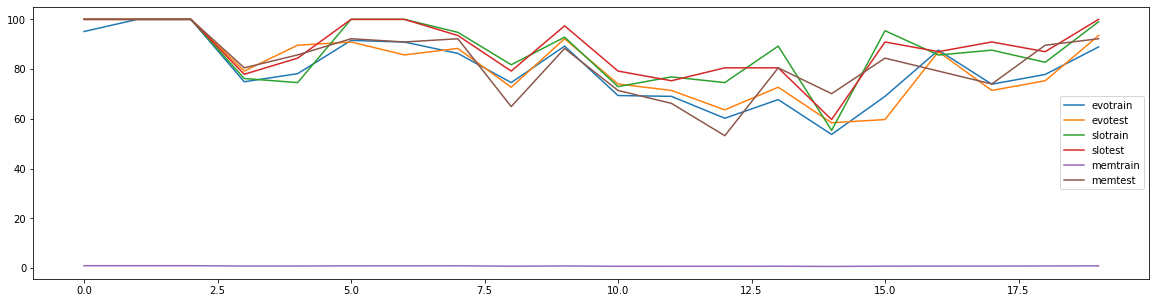

In [56]:
figsize(20,5)
evoTrainRes = [(1-x.fitness.values[0]) * 100 for x in evoRes]
evoTestRes=[(1-testIndividual(x,i)) * 100 for i,x in enumerate(evoRes)]
sloTrainRes = [x['trainDataScore'] for i,x in enumerate(booscRes)]
sloTestRes = [x['testDataScore'] for i,x in enumerate(booscRes)]
memTrainRes = [x['trainScore'] for i,x in enumerate(memzRes)]
memTestRes = [x['testScore'] for i,x in enumerate(memzRes)]
plot(evoTrainRes, label='evotrain')
plot(evoTestRes, label='evotest')
plot(sloTrainRes, label='slotrain')
plot(sloTestRes, label='slotest')
plot(memTrainRes, label='memtrain')
plot(memTestRes, label='memtest')
plt.legend()
# evoTrainRes

In [57]:
modelSizes=[sum(x['cfg']['LAYERS']) for x in booscRes]
modelSizes

[213,
 213,
 213,
 213,
 853,
 853,
 3413,
 3413,
 3413,
 3413,
 426,
 426,
 6826,
 6826,
 426,
 6826,
 213,
 3413,
 853,
 3413]

In [58]:
import pandas as pd
exptIdx = range(len(sloTestRes))
df = pd.DataFrame(list(zip(exptIdx,evoTestRes, sloTestRes, memTestRes, modelSizes)),
               columns =['expt','GA', 'SLO', 'MEM','LUTs'])
dfs=df.sort_values(by=['SLO','GA','MEM'], ascending=False)
dfs

,expt,GA,SLO,MEM,LUTs
0,0,100.000000,100.000000,100.000000,213
1,1,100.000000,100.000000,100.000000,213
2,2,100.000000,100.000000,100.000000,213
19,19,93.506494,100.000000,92.207792,3413
5,5,90.909091,100.000000,92.207792,853
6,6,85.714286,100.000000,90.909091,3413
9,9,92.207792,97.402597,88.311688,3413
7,7,88.311688,93.506494,92.207792,3413
17,17,71.428571,90.909091,74.025974,3413
15,15,59.740260,90.909091,84.415584,6826


In [61]:
allRes = concatenate((evoTestRes, sloTestRes, memTestRes))
allRes

array([100.        , 100.        , 100.        ,  79.22077922,
        89.61038961,  90.90909091,  85.71428571,  88.31168831,
        72.72727273,  92.20779221,  74.02597403,  71.42857143,
        63.63636364,  72.72727273,  58.44155844,  59.74025974,
        87.01298701,  71.42857143,  75.32467532,  93.50649351,
       100.        , 100.        , 100.        ,  77.92207792,
        84.41558442, 100.        , 100.        ,  93.50649351,
        79.22077922,  97.4025974 ,  79.22077922,  75.32467532,
        80.51948052,  80.51948052,  59.74025974,  90.90909091,
        87.01298701,  90.90909091,  87.01298701, 100.        ,
       100.        , 100.        , 100.        ,  80.51948052,
        85.71428571,  92.20779221,  90.90909091,  92.20779221,
        64.93506494,  88.31168831,  71.42857143,  66.23376623,
        53.24675325,  80.51948052,  70.12987013,  84.41558442,
        79.22077922,  74.02597403,  89.61038961,  92.20779221])

In [59]:
model = concatenate((tile('GA',20), tile('SLO',20), tile('MEM',20)))
model

array(['GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA',
       'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'GA', 'SLO', 'SLO',
       'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO',
       'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO', 'SLO',
       'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM',
       'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM', 'MEM',
       'MEM', 'MEM'], dtype='<U3')

In [62]:
modelSizes2 = tile(modelSizes,3)
modelSizes2

array([ 213,  213,  213,  213,  853,  853, 3413, 3413, 3413, 3413,  426,
        426, 6826, 6826,  426, 6826,  213, 3413,  853, 3413,  213,  213,
        213,  213,  853,  853, 3413, 3413, 3413, 3413,  426,  426, 6826,
       6826,  426, 6826,  213, 3413,  853, 3413,  213,  213,  213,  213,
        853,  853, 3413, 3413, 3413, 3413,  426,  426, 6826, 6826,  426,
       6826,  213, 3413,  853, 3413])

In [63]:
df = pd.DataFrame(list(zip(np.tile(range(20),3),allRes, model, modelSizes2)),
               columns =['expt','Score','Model','LUTs'])
df

,expt,Score,Model,LUTs
0,0,100.000000,GA,213
1,1,100.000000,GA,213
2,2,100.000000,GA,213
3,3,79.220779,GA,213
4,4,89.610390,GA,853
5,5,90.909091,GA,853
6,6,85.714286,GA,3413
7,7,88.311688,GA,3413
8,8,72.727273,GA,3413
9,9,92.207792,GA,3413


<AxesSubplot:xlabel='Model', ylabel='Score'>

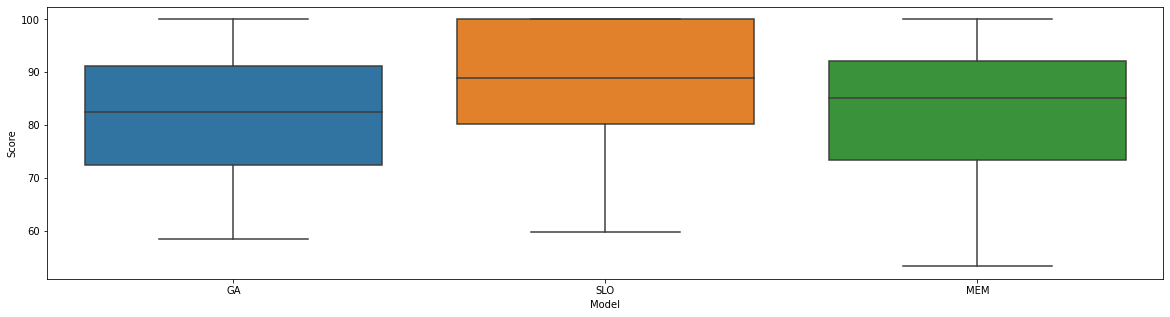

In [64]:
import seaborn as sns
sns.boxplot(data=df, x='Model', y='Score')



<AxesSubplot:title={'center':'B: Score by LUT Count'}, xlabel='LUTs', ylabel='Score'>

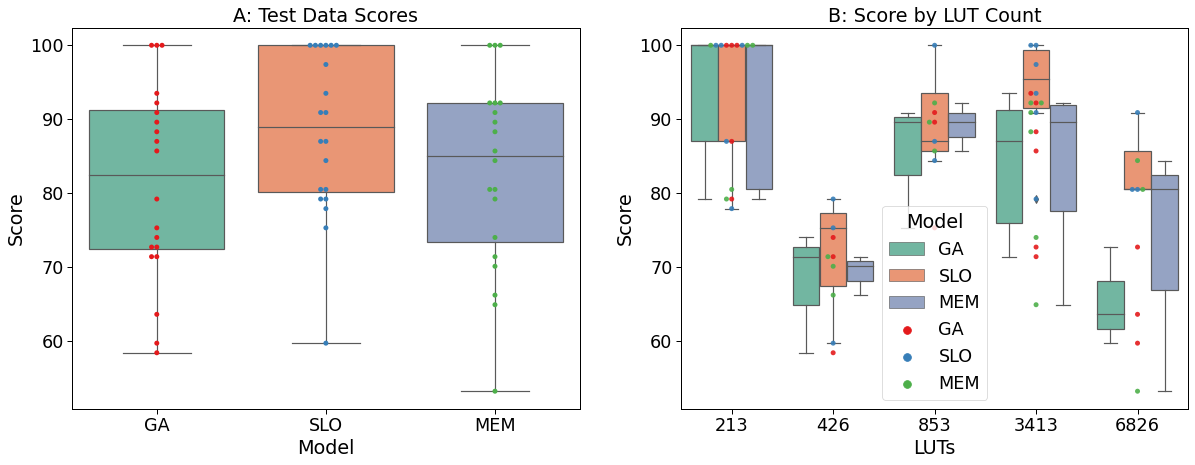

In [65]:
figsize(20,7)
sns.set_context("paper", font_scale=2)
subplot(1,2,1)
sns.boxplot(data=df, x='Model', y='Score', palette='Set2').set_title('A: Test Data Scores')
sns.swarmplot(data=df, x='Model', y='Score', palette='Set1').set_title('A: Test Data Scores')
subplot(1,2,2)
sns.boxplot(data=df, x='LUTs', y='Score',hue='Model', palette='Set2').set_title('B: Score by LUT Count')
sns.swarmplot(data=df, x='LUTs', y='Score',hue='Model', palette='Set1', alpha=0.9)


In [66]:
evoTestRes

[100.0,
 100.0,
 100.0,
 79.22077922077922,
 89.6103896103896,
 90.9090909090909,
 85.71428571428571,
 88.31168831168831,
 72.72727272727273,
 92.20779220779221,
 74.02597402597402,
 71.42857142857143,
 63.63636363636363,
 72.72727272727273,
 58.44155844155844,
 59.74025974025974,
 87.01298701298701,
 71.42857142857143,
 75.32467532467533,
 93.5064935064935]

In [67]:
memTestRes

[100.0,
 100.0,
 100.0,
 80.51948051948052,
 85.71428571428571,
 92.20779220779221,
 90.9090909090909,
 92.20779220779221,
 64.93506493506493,
 88.31168831168831,
 71.42857142857143,
 66.23376623376623,
 53.246753246753244,
 80.51948051948052,
 70.12987012987013,
 84.4155844155844,
 79.22077922077922,
 74.02597402597402,
 89.6103896103896,
 92.20779220779221]

In [68]:
from scipy.stats import normaltest, shapiro
print(normaltest(evoTestRes))
print(normaltest(sloTestRes))
print(normaltest(memTestRes))
print(shapiro(evoTestRes))
print(shapiro(sloTestRes))
print(shapiro(memTestRes))

NormaltestResult(statistic=2.0785254192995577, pvalue=0.3537153767771064)
NormaltestResult(statistic=2.722411421326594, pvalue=0.2563515048017652)
NormaltestResult(statistic=1.3867757423757843, pvalue=0.4998796691678594)
ShapiroResult(statistic=0.9386261701583862, pvalue=0.22583475708961487)
ShapiroResult(statistic=0.890571117401123, pvalue=0.027550451457500458)
ShapiroResult(statistic=0.9478420615196228, pvalue=0.3355177640914917)


In [182]:
print(mean(evoTestRes), median(evoTestRes))

81.29870129870129 82.46753246753246


In [183]:
print(mean(sloTestRes), median(sloTestRes))

88.18181818181817 88.96103896103895


In [69]:
print(mean(memTestRes), median(memTestRes))

82.79220779220779 85.06493506493506


In [70]:
from scipy.stats import wilcoxon,mannwhitneyu,ttest_rel
stat, p = wilcoxon(evoTestRes, sloTestRes)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=7.000, p=0.002


/home/ck84/miniconda3/envs/conda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2967: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [71]:
from scipy.stats import wilcoxon,mannwhitneyu,ttest_rel
stat, p = wilcoxon(memTestRes, sloTestRes)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=22.000, p=0.017


In [72]:
from scipy.stats import wilcoxon,mannwhitneyu,ttest_rel
stat, p = wilcoxon(memTestRes, evoTestRes)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=67.500, p=0.670
